# RSNA-MICCAI Brain Tumor Radiogenomic Classification

The Radiological Society of North America (RSNA), the American Society of Neuroradiology (ASNR), and the
Medical Image Computing and Computer Assisted Interventions (MICCAI) society has teamed up with Kaggle for a codding competition to predict the status of a genetic biomarker (MGMT) important for brain cancer treatment. Using patient MRI scan findings (*), I created a ResNet-50 model to detect the existence of glioblastoma multiforme.

* Citation : U.Baid, et al., “The RSNA-ASNR-MICCAI BraTS 2021 Benchmark on Brain Tumor Segmentation and Radiogenomic Classification”, arXiv:2107.02314, 2021.


In [251]:
#import packages 
import numpy as np 
import pandas as pd
import os
import copy
from math import *
import matplotlib.pyplot as plt
from functools import reduce
from glob import glob
%matplotlib inline
import cv2 as cv
import seaborn as sns
import pydicom as dicom  #reading in dicom files
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD

# Data retrieval and EDA

In [2]:
#read lables data
train_df = pd.read_csv('C:/Users/OliverLab/Documents/Jishnu/Kaggle GBM comp/Dataset/train_labels.csv')
test_df = pd.read_csv('C:/Users/OliverLab/Documents/Jishnu/Kaggle GBM comp/Dataset/sample_submission.csv')


In [164]:
#data cleansing
samples_to_exclude = [109, 123, 709]
train_df = train_df[~train_df.BraTS21ID.isin(samples_to_exclude)]
test_df = test_df[~test_df.BraTS21ID.isin(samples_to_exclude)]

For each patient, the training data provides the target value MGMT value, which is the presence of MGMT promoter methylation in MRI scans. The methylation state of the MGMT promoter is specified as a binary label (0: unmethylated, 1: methylated).

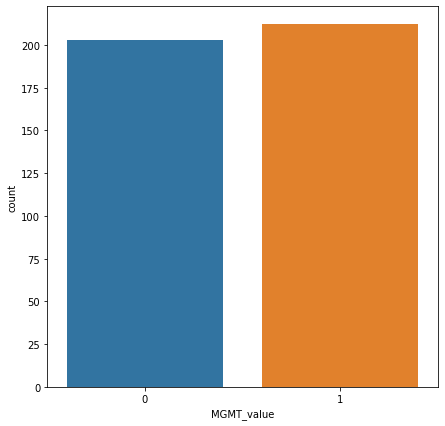

In [279]:
#display the training data 
plt.figure(figsize=(7,7))
sns.countplot(data=train_df, x="MGMT_value");


In [32]:
train_data,val_data = train_test_split(train_df, test_size = .2, random_state = 42, stratify=train_df["MGMT_value"])

In [33]:
data_path_train = 'C:/Users/OliverLab/Documents/Jishnu/Kaggle GBM comp/Train set'
patients = os.listdir(data_path_train)
patients.sort()


In [34]:
#list of dicom files

patient_file = []
for dir_name, subdir_list, file_list in os.walk(data_path_train):
    for file_name in file_list:
        if ".dcm" in file_name.lower():
            patient_file.append(os.path.join(dir_name,file_name))
            
          

print(f"Number of patients: {len(patients)}")
print("Number of (.dicom) files =", len(patient_file))


Number of patients: 417
Number of (.dicom) files = 227037


An ID number of five digits is used to identify the patient's information. Each patient has four different sorts of structural multi-parametric MRI (mpMRI) scan files in DICOM format:

    Fluid Attenuated Inversion Recovery (FLAIR)
    T1-weighted pre-contrast (T1w)
    T1-weighted post-contrast (T1Gd)
    T2-weighted (T2)
    
Let's take a look at a random patient's scan report.

Patient Id: 00000
Scan Type:FLAIR


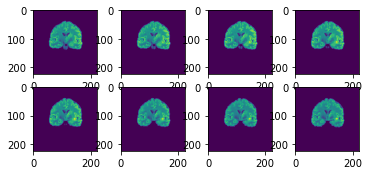

Scan Type:T1w


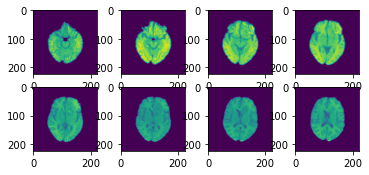

Scan Type:T1wCE


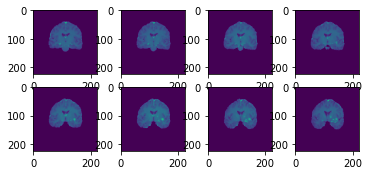

Scan Type:T2w


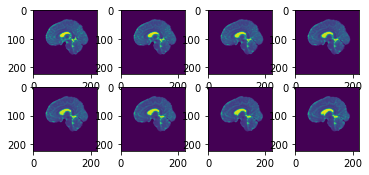

In [249]:
IMG_PX_SIZE = 224
for patient in patients[0:1]:
    print(f"Patient Id: {patient}")    
    path = data_path_train + '/' + patient
    # Identify scan types
    patient_scan_types = os.listdir(path)
    for scan_type in patient_scan_types:
        dicom_path = path + '/' + scan_type +'/*.dcm'
        dicom_files = sorted(glob(dicom_path),key=lambda f: int(f.split('Image-')[1].split('.')[0]))
        slices = [dicom.read_file(file)for file in dicom_files]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        print(f"Scan Type:{scan_type}")
        fig = plt.figure()
        mid = len(slices)//2
        for num, dicom_slice in enumerate(slices[mid-4:mid+4]):
            y = fig.add_subplot(3,4,num+1)
            img = cv.resize(np.array(dicom_slice.pixel_array),(IMG_PX_SIZE, IMG_PX_SIZE))
            plt.imshow(img)
        plt.show()

In [106]:
def load_dicom_files(patient_id): 
    path = data_path_train + '/' + patient_id
    # Identify scan types
    patient_scan_types = os.listdir(path)
    for scan_type in patient_scan_types:
        dicom_path = path + '/' + scan_type +'/*.dcm'
        dicom_files = sorted(glob(dicom_path),key=lambda f: int(f.split('Image-')[1].split('.')[0]))
        for file in dicom_files:
             data = dicom.read_file(file)
             data = data.pixel_array
             if np.max(data) != 0:
                data = data / np.max(data)
             data = (data * 255).astype(np.uint8)
             image = cv.resize(np.array(data),(IMG_PX_SIZE, IMG_PX_SIZE))
             image += image
    return np.array(image)
       

In [107]:
def load_train_data():
    x_train = []
    y_train = []
    for i in tqdm(train_data.index):
        k = train_data.loc[i]
        patient_ID = k['BraTS21ID']
        label =  k['MGMT_value']
        image = load_dicom_files(str(patient_ID).zfill(5))
        x_train.append(image)
        y_train.append(label)
    return(np.array(x_train),np.array(y_train))

In [108]:
def load_val_data():
    x_val = []
    y_val = []
    for i in tqdm(val_data.index):
        k = val_data.loc[i]
        patient_ID = k['BraTS21ID']
        label =  k['MGMT_value']
        image = load_dicom_files(str(patient_ID).zfill(5))
        x_val.append(image)
        y_val.append(label)
    return(np.array(x_val),np.array(y_val))

In [109]:
#load training data
x_train,y_train = load_train_data()

  0%|          | 0/332 [00:00<?, ?it/s]

In [110]:
#validation data
x_val,y_val = load_val_data()

  0%|          | 0/83 [00:00<?, ?it/s]

In [111]:
y_val.shape

(83,)

In [112]:
np.shape(x_train)

(332, 224, 224)

In [113]:
#expand the dimension of traing,val  data
x_train = tf.expand_dims(x_train,axis = -1)
x_val = tf.expand_dims(x_val,axis = -1)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)


In [114]:
np.shape(y_train)

(332, 2)

# Model preparation

In [130]:
#identity block
def identity_block(x,f,filters):
    x_skip = x
    f1,f2,f3 = filters
    x = tf.keras.layers.Conv2D(filters = f1,kernel_size =(3,3),strides = (1,1), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filters = f2,kernel_size = (f,f),strides = (1,1), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 3
    x = tf.keras.layers.Conv2D(filters = f3,kernel_size = (1,1),strides = (1,1), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def conv_block(x,f,s,filters):
    x_skip = x
    f1,f2,f3 = filters
    #layer 1
    x = tf.keras.layers.Conv2D(filters = f1,kernel_size = (1,1),strides = (s,s))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    #layer 2
    x = tf.keras.layers.Conv2D(filters = f2, kernel_size = (f,f), padding = 'same',strides = (1,1))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    #layer 3
    x = tf.keras.layers.Conv2D(filters = f3, kernel_size = (1,1), padding = 'same',strides = (1,1))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filters = f3, kernel_size = (1,1), strides = (s,s),padding = 'same')(x_skip)
    x_skip = tf.keras.layers.BatchNormalization(axis=3)(x_skip)
    
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

def resnet50(input_shape = (224,224,1),classes = 2):
    #input layer 
    x_input = keras.Input(input_shape)
    #padding layer
    k = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
 
    #  1
    k = tf.keras.layers.Conv2D(64, kernel_size=(4,4), strides=(2,2), padding='valid')(k)
    k = tf.keras.layers.BatchNormalization(axis=3)(k)
    k = tf.keras.layers.Activation('relu')(k)
    k = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides= (2,2),padding='same')(k)
    #stage 2
    k = conv_block(k,f = 3,filters=[64,64,256],s =1)
    
    k =  identity_block(k,f = 3,filters=[64,64,256])
    
    k =  identity_block(k,f = 3,filters=[64,64,256])
    
    #stage 3
    k = conv_block(k,f = 3,filters=[128,128,512],s =2)
    
    k =  identity_block(k,f = 3,filters=[128,128,512])
    k =  identity_block(k,f = 3,filters=[128,128,512])
    k =  identity_block(k,f = 3,filters=[128,128,512])
    
   #stage 4
    k = conv_block(k,f = 3,filters=[256,256,1024],s =2)
    
    k =  identity_block(k,f = 3,filters=[256,256,1024])
    k =  identity_block(k,f = 3,filters=[256,256,1024])
    k =  identity_block(k,f = 3,filters=[256,256,1024])
    k =  identity_block(k,f = 3,filters=[256,256,1024])
    k =  identity_block(k,f = 3,filters=[256,256,1024])
    
    #stage 5
    k = conv_block(k,f = 3,filters=[512,512,2048],s =2)
    
    k =  identity_block(k,f = 3,filters=[512,512,2048])
    k =  identity_block(k,f = 3,filters=[512,512,2048])   
    
    #avg pool layer
    k = tf.keras.layers.AveragePooling2D((4, 4))(k)
    # output layer

   

    k = keras.layers.Flatten()(k) 
   

    output = keras.layers.Dense(2, activation="softmax")(k)

    

    model = tf.keras.models.Model(inputs = x_input, outputs = output, name = "ResNet50")
    return model

In [131]:
model = resnet50(input_shape = (224,224,1),classes = 2)

In [132]:
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate =0.0001), loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC()])

In [133]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_7 (ZeroPadding2  (None, 230, 230, 1)  0          ['input_8[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_371 (Conv2D)            (None, 114, 114, 64  1088        ['zero_padding2d_7[0][0]']       
                                )                                                          

In [134]:
history = model.fit(x= x_train, y = y_train, epochs=75, validation_data= (x_val, y_val))

Epoch 1/75
11/11 [==============================] - 782s 70s/step - loss: 0.8100 - auc_3: 0.5482 - val_loss: 0.6949 - val_auc_3: 0.4946
Epoch 2/75
11/11 [==============================] - 695s 63s/step - loss: 0.7132 - auc_3: 0.5546 - val_loss: 0.6946 - val_auc_3: 0.4943
Epoch 3/75
11/11 [==============================] - 690s 63s/step - loss: 0.7239 - auc_3: 0.4497 - val_loss: 0.7442 - val_auc_3: 0.5126
Epoch 4/75
11/11 [==============================] - 691s 63s/step - loss: 0.7464 - auc_3: 0.5333 - val_loss: 0.6990 - val_auc_3: 0.4953
Epoch 5/75
11/11 [==============================] - 691s 63s/step - loss: 0.6997 - auc_3: 0.5059 - val_loss: 0.6963 - val_auc_3: 0.5054
Epoch 6/75
11/11 [==============================] - 691s 63s/step - loss: 0.7020 - auc_3: 0.5207 - val_loss: 0.6980 - val_auc_3: 0.4943
Epoch 7/75
11/11 [==============================] - 687s 63s/step - loss: 0.7038 - auc_3: 0.5587 - val_loss: 0.7328 - val_auc_3: 0.4993
Epoch 8/75
11/11 [==============================

# Model Testing

In [179]:
data_path_test = 'C:/Users/OliverLab/Documents/Jishnu/Kaggle GBM comp/Dataset/test'
def load_test_dicom_files(patient_id): 
    path = data_path_test + '/' + patient_id
    # Identify scan types
    patient_scan_types = os.listdir(path)
    for scan_type in patient_scan_types:
        dicom_path = path + '/' + scan_type +'/*.dcm'
        dicom_files = sorted(glob(dicom_path),key=lambda f: int(f.split('Image-')[1].split('.')[0]))
        for file in dicom_files:
             data = dicom.read_file(file)
             data = data.pixel_array
             if np.max(data) != 0:
                data = data / np.max(data)
             data = (data * 255).astype(np.uint8)
             image = cv.resize(np.array(data),(IMG_PX_SIZE, IMG_PX_SIZE))
             image += image
    return np.array(image)

In [185]:
def load_test_data():
    x_test = []
    test_ids = []
    for i in tqdm(test_df.index):
        k = test_df.loc[i]
        patient_ID = k['BraTS21ID']
        patient_ID = int(patient_ID)
        image = load_test_dicom_files(f'{patient_ID:05}')
        x_test.append(image)
        test_ids.append(int(k['BraTS21ID']))
    return(np.array(x_test),np.array(test_ids))

In [186]:
#load testing data
x_test,test_ids = load_test_data()

  0%|          | 0/87 [00:00<?, ?it/s]

In [190]:
#model prediction
y_pred = model.predict(x_test)
final_pred = np.amax(y_pred, axis=1)

In [247]:
#create a dataframe
submission = pd.DataFrame(test_ids)
submission[1]=final_pred
#add columns to the dataframe
submission.columns=['BraTS21ID','MGMT_value']
submission.tail()

,BraTS21ID,MGMT_value
82,826,0.505361
83,829,0.678242
84,833,0.505361
85,997,0.505361
86,1006,0.505361


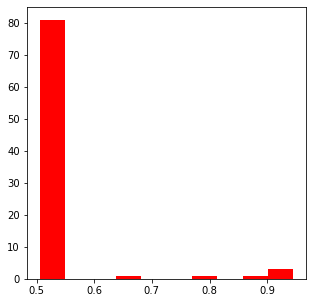

In [256]:
plt.figure(figsize=(5, 5))
plt.hist(submission["MGMT_value"],color = 'red');